In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv('WineQT.csv')
X = df.drop('quality', axis=1)
y = df['quality']
y = (y >= 6).astype(int)

# Feature engineering
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

class ImprovedAttentionModel(nn.Module):
    def __init__(self, input_dim, attention_dim, hidden_dim, num_classes, dropout_rate=0.5):
        super(ImprovedAttentionModel, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, attention_dim),
            nn.ReLU(),
            nn.Linear(attention_dim, 1)
        )
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        attention_weights = F.softmax(self.attention(x), dim=1)
        weighted_features = x * attention_weights
        x = self.dropout(F.leaky_relu(self.bn1(self.fc1(weighted_features))))
        x = self.dropout(F.leaky_relu(self.bn2(self.fc2(x))))
        output = self.fc3(x)
        return output, weighted_features, attention_weights

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=200):
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs, _, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        scheduler.step(loss)
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs, _, _ = model(X_test_tensor)
                _, predicted = torch.max(test_outputs.data, 1)
                accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
                print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.4f}')

    return model

input_dim = X_train_scaled.shape[1]
attention_dim = 128
hidden_dim = 256
num_classes = 2
dropout_rate = 0.5
learning_rate = 0.001
batch_size = 64
num_epochs = 300

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"Fold {fold + 1}")
    
    X_train_fold = X_train_tensor[train_idx]
    y_train_fold = y_train_tensor[train_idx]
    X_val_fold = X_train_tensor[val_idx]
    y_val_fold = y_train_tensor[val_idx]
    
    model = ImprovedAttentionModel(input_dim, attention_dim, hidden_dim, num_classes, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
    
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs)
    
    model.eval()
    with torch.no_grad():
        val_outputs, _, _ = model(X_val_fold)
        _, predicted = torch.max(val_outputs.data, 1)
        accuracy = accuracy_score(y_val_fold.cpu(), predicted.cpu())
        cv_scores.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Train the final model on the entire training set
final_model = ImprovedAttentionModel(input_dim, attention_dim, hidden_dim, num_classes, dropout_rate).to(device)
final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=1e-4)
final_scheduler = ReduceLROnPlateau(final_optimizer, 'min', patience=10, factor=0.5, verbose=True)

final_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
final_train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True)

final_model = train_model(final_model, final_train_loader, final_criterion, final_optimizer, final_scheduler, num_epochs)

# Extract attention-weighted features
final_model.eval()
with torch.no_grad():
    _, train_features, _ = final_model(X_train_tensor)
    _, test_features, _ = final_model(X_test_tensor)

train_features = train_features.cpu().numpy()
test_features = test_features.cpu().numpy()

# Create an ensemble of multiple models
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

knn.fit(train_features, y_train)
rf.fit(train_features, y_train)
gb.fit(train_features, y_train)

knn_predictions = knn.predict(test_features)
rf_predictions = rf.predict(test_features)
gb_predictions = gb.predict(test_features)
nn_predictions = final_model(X_test_tensor)[0].argmax(dim=1).cpu().numpy()

ensemble_predictions = np.round((knn_predictions + rf_predictions + gb_predictions + nn_predictions) / 4).astype(int)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print(f"KNN Accuracy: {accuracy_score(y_test, knn_predictions):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, gb_predictions):.4f}")
print(f"Neural Network Accuracy: {accuracy_score(y_test, nn_predictions):.4f}")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

Using device: cuda
Fold 1


c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7594
Epoch [20/300], Test Accuracy: 0.7500
Epoch [30/300], Test Accuracy: 0.7562
Epoch [40/300], Test Accuracy: 0.7625
Epoch [50/300], Test Accuracy: 0.7594
Epoch [60/300], Test Accuracy: 0.7688
Epoch [70/300], Test Accuracy: 0.7750
Epoch [80/300], Test Accuracy: 0.7688
Epoch [90/300], Test Accuracy: 0.7688
Epoch [100/300], Test Accuracy: 0.7688
Epoch [110/300], Test Accuracy: 0.7625
Epoch [120/300], Test Accuracy: 0.7688
Epoch [130/300], Test Accuracy: 0.7688
Epoch [140/300], Test Accuracy: 0.7719
Epoch [150/300], Test Accuracy: 0.7656
Epoch [160/300], Test Accuracy: 0.7719
Epoch [170/300], Test Accuracy: 0.7688
Epoch [180/300], Test Accuracy: 0.7656
Epoch [190/300], Test Accuracy: 0.7688
Epoch [200/300], Test Accuracy: 0.7688
Epoch [210/300], Test Accuracy: 0.7656
Epoch [220/300], Test Accuracy: 0.7656
Epoch [230/300], Test Accuracy: 0.7688
Epoch [240/300], Test Accuracy: 0.7688
Epoch [250/300], Test Accuracy: 0.7688
Epoch [260/300], Test Accuracy: 0.

c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7469
Epoch [20/300], Test Accuracy: 0.7500
Epoch [30/300], Test Accuracy: 0.7562
Epoch [40/300], Test Accuracy: 0.7531
Epoch [50/300], Test Accuracy: 0.7656
Epoch [60/300], Test Accuracy: 0.7656
Epoch [70/300], Test Accuracy: 0.7625
Epoch [80/300], Test Accuracy: 0.7625
Epoch [90/300], Test Accuracy: 0.7656
Epoch [100/300], Test Accuracy: 0.7656
Epoch [110/300], Test Accuracy: 0.7625
Epoch [120/300], Test Accuracy: 0.7625
Epoch [130/300], Test Accuracy: 0.7656
Epoch [140/300], Test Accuracy: 0.7656
Epoch [150/300], Test Accuracy: 0.7656
Epoch [160/300], Test Accuracy: 0.7594
Epoch [170/300], Test Accuracy: 0.7656
Epoch [180/300], Test Accuracy: 0.7656
Epoch [190/300], Test Accuracy: 0.7688
Epoch [200/300], Test Accuracy: 0.7656
Epoch [210/300], Test Accuracy: 0.7625
Epoch [220/300], Test Accuracy: 0.7656
Epoch [230/300], Test Accuracy: 0.7625
Epoch [240/300], Test Accuracy: 0.7688
Epoch [250/300], Test Accuracy: 0.7656
Epoch [260/300], Test Accuracy: 0.

c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7375
Epoch [20/300], Test Accuracy: 0.7344
Epoch [30/300], Test Accuracy: 0.7594
Epoch [40/300], Test Accuracy: 0.7438
Epoch [50/300], Test Accuracy: 0.7344
Epoch [60/300], Test Accuracy: 0.7406
Epoch [70/300], Test Accuracy: 0.7375
Epoch [80/300], Test Accuracy: 0.7469
Epoch [90/300], Test Accuracy: 0.7375
Epoch [100/300], Test Accuracy: 0.7375
Epoch [110/300], Test Accuracy: 0.7500
Epoch [120/300], Test Accuracy: 0.7406
Epoch [130/300], Test Accuracy: 0.7438
Epoch [140/300], Test Accuracy: 0.7469
Epoch [150/300], Test Accuracy: 0.7531
Epoch [160/300], Test Accuracy: 0.7406
Epoch [170/300], Test Accuracy: 0.7469
Epoch [180/300], Test Accuracy: 0.7500
Epoch [190/300], Test Accuracy: 0.7500
Epoch [200/300], Test Accuracy: 0.7438
Epoch [210/300], Test Accuracy: 0.7500
Epoch [220/300], Test Accuracy: 0.7469
Epoch [230/300], Test Accuracy: 0.7406
Epoch [240/300], Test Accuracy: 0.7469
Epoch [250/300], Test Accuracy: 0.7469
Epoch [260/300], Test Accuracy: 0.

c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7438
Epoch [20/300], Test Accuracy: 0.7594
Epoch [30/300], Test Accuracy: 0.7781
Epoch [40/300], Test Accuracy: 0.7750
Epoch [50/300], Test Accuracy: 0.7812
Epoch [60/300], Test Accuracy: 0.7906
Epoch [70/300], Test Accuracy: 0.7844
Epoch [80/300], Test Accuracy: 0.7875
Epoch [90/300], Test Accuracy: 0.7875
Epoch [100/300], Test Accuracy: 0.7844
Epoch [110/300], Test Accuracy: 0.7875
Epoch [120/300], Test Accuracy: 0.7906
Epoch [130/300], Test Accuracy: 0.7906
Epoch [140/300], Test Accuracy: 0.7906
Epoch [150/300], Test Accuracy: 0.7906
Epoch [160/300], Test Accuracy: 0.7906
Epoch [170/300], Test Accuracy: 0.7906
Epoch [180/300], Test Accuracy: 0.7906
Epoch [190/300], Test Accuracy: 0.7937
Epoch [200/300], Test Accuracy: 0.7844
Epoch [210/300], Test Accuracy: 0.7875
Epoch [220/300], Test Accuracy: 0.7906
Epoch [230/300], Test Accuracy: 0.7812
Epoch [240/300], Test Accuracy: 0.7906
Epoch [250/300], Test Accuracy: 0.7906
Epoch [260/300], Test Accuracy: 0.

c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7438
Epoch [20/300], Test Accuracy: 0.7375
Epoch [30/300], Test Accuracy: 0.7406
Epoch [40/300], Test Accuracy: 0.7375
Epoch [50/300], Test Accuracy: 0.7406
Epoch [60/300], Test Accuracy: 0.7438
Epoch [70/300], Test Accuracy: 0.7438
Epoch [80/300], Test Accuracy: 0.7438
Epoch [90/300], Test Accuracy: 0.7438
Epoch [100/300], Test Accuracy: 0.7438
Epoch [110/300], Test Accuracy: 0.7469
Epoch [120/300], Test Accuracy: 0.7469
Epoch [130/300], Test Accuracy: 0.7469
Epoch [140/300], Test Accuracy: 0.7469
Epoch [150/300], Test Accuracy: 0.7469
Epoch [160/300], Test Accuracy: 0.7469
Epoch [170/300], Test Accuracy: 0.7469
Epoch [180/300], Test Accuracy: 0.7469
Epoch [190/300], Test Accuracy: 0.7469
Epoch [200/300], Test Accuracy: 0.7469
Epoch [210/300], Test Accuracy: 0.7469
Epoch [220/300], Test Accuracy: 0.7406
Epoch [230/300], Test Accuracy: 0.7438
Epoch [240/300], Test Accuracy: 0.7438
Epoch [250/300], Test Accuracy: 0.7438
Epoch [260/300], Test Accuracy: 0.

c:\Users\Thoma\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/300], Test Accuracy: 0.7500
Epoch [20/300], Test Accuracy: 0.7531
Epoch [30/300], Test Accuracy: 0.7438
Epoch [40/300], Test Accuracy: 0.7625
Epoch [50/300], Test Accuracy: 0.7562
Epoch [60/300], Test Accuracy: 0.7656
Epoch [70/300], Test Accuracy: 0.7656
Epoch [80/300], Test Accuracy: 0.7719
Epoch [90/300], Test Accuracy: 0.7625
Epoch [100/300], Test Accuracy: 0.7688
Epoch [110/300], Test Accuracy: 0.7719
Epoch [120/300], Test Accuracy: 0.7688
Epoch [130/300], Test Accuracy: 0.7656
Epoch [140/300], Test Accuracy: 0.7719
Epoch [150/300], Test Accuracy: 0.7656
Epoch [160/300], Test Accuracy: 0.7625
Epoch [170/300], Test Accuracy: 0.7594
Epoch [180/300], Test Accuracy: 0.7656
Epoch [190/300], Test Accuracy: 0.7656
Epoch [200/300], Test Accuracy: 0.7625
Epoch [210/300], Test Accuracy: 0.7656
Epoch [220/300], Test Accuracy: 0.7719
Epoch [230/300], Test Accuracy: 0.7625
Epoch [240/300], Test Accuracy: 0.7656
Epoch [250/300], Test Accuracy: 0.7625
Epoch [260/300], Test Accuracy: 0.

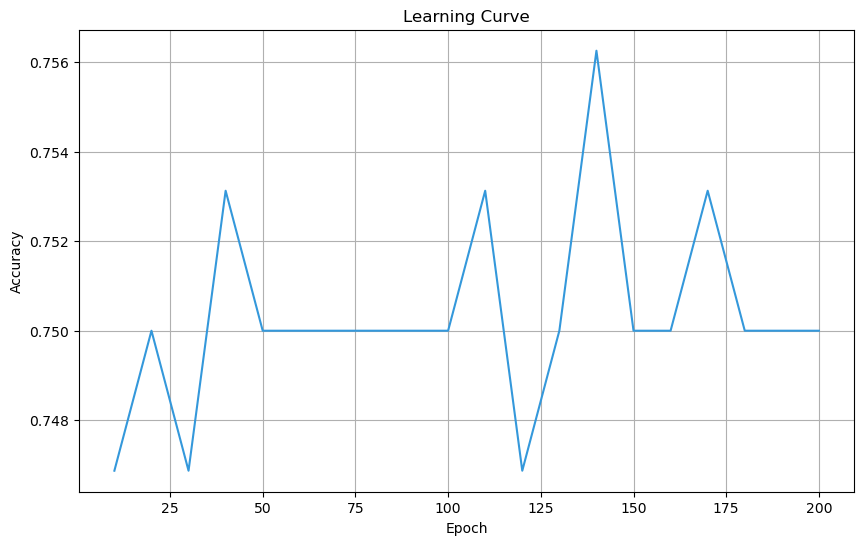

In [17]:
import matplotlib.pyplot as plt

epochs, accs = zip(*accuracies)
plt.figure(figsize=(10, 6))
plt.plot(epochs, accs, color='#3498db')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [18]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np

knn_f1 = f1_score(y_test, knn_predictions)
nn_f1 = f1_score(y_test, nn_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)

# Create a dictionary with the results
model_comp = {
    'KNN': [knn_accuracy, knn_f1],
    'Neural Network': [accuracy_score(y_test, nn_predictions), nn_f1],
    'Ensemble': [ensemble_accuracy, ensemble_f1]
}

# Create a DataFrame from the dictionary
df1 = pd.DataFrame.from_dict(model_comp).T
df1.columns = ['Accuracy', 'F1_score']

df1 = df1.sort_values('F1_score', ascending=True)

styled_df = df1.style.background_gradient(cmap='Greens')

styled_df = styled_df.format({
    'Accuracy': '{:.4f}',
    'F1_score': '{:.4f}'
})

display(styled_df)

,Accuracy,F1_score
KNN,0.7063,0.7601
Neural Network,0.7594,0.7781
Ensemble,0.7812,0.7953
